In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import qt3utils.experiments.cwodmr
import qt3utils.nidaq.config

In [3]:
import qcsapphire
import qt3rfsynthcontrol
import numpy as np
import matplotlib.pyplot as plt

In [4]:
qcsapphire.discover_devices()

[['COM3',
  'Intel(R) Active Management Technology - SOL (COM3)',
  'PCI\\VEN_8086&DEV_43E3&SUBSYS_0A541028&REV_11\\3&11583659&1&B3'],
 ['COM5',
  'USB Serial Device (COM5)',
  'USB VID:PID=0483:A3E5 SER=206A36705430 LOCATION=1-9:x.0'],
 ['COM7',
  'USB Serial Device (COM7)',
  'USB VID:PID=239A:8014 SER=3B0D07C25831555020312E341A3214FF LOCATION=1-10:x.0'],
 ['COM10',
  'USB Serial Device (COM10)',
  'USB VID:PID=04D8:000A SER= LOCATION=1-2:x.0']]

In [5]:
pulser = qcsapphire.Pulser('COM10')

In [6]:
rfsynth = qt3rfsynthcontrol.QT3SynthHD('COM5')

In [9]:
#cwodmr = qt3utils.experiments.cwodmr.CWODMR(rfsynth)

In [12]:
#cwodmr.setup_qcsapphire_pulser(pulser, 'B', 'C')

In [13]:
pulser.query('*RCL 0') #restores system default
pulser.system.period(cwodmr.sample_period)
pulser.system.mode('normal')

'ok'

In [14]:
pulser.set_all_state_off()

In [9]:
pulser.channel('C').width(100e-6)

'ok'

In [17]:
pulser.channel('C').state(1)

'ok'

In [18]:
pulser.system.state(1)

'ok'

In [20]:
pulser.channel('B').width(cwodmr.sample_period/2 - 20e-9)

'ok'

In [21]:
pulser.channel('B').state(1)

'ok'

In [11]:
pulser.multiplex(['B'], 'D')
pulser.channel('D').state(1)

'ok'

In [96]:
import nidaqmx

nisys = nidaqmx.system.System()
device = nidaqmx.system.Device('Dev1')
device.reset_device()

In [125]:
edge_config = qt3utils.nidaq.config.EdgeCounter()

In [126]:
edge_config.configure_di_clock(clock_rate = 100e3)

In [127]:
edge_config.clock_task_config

{'di_channel_name': 'port0',
 'clock_rate': 100000,
 'clock_channel_name': '/Dev1/di/SampleClock',
 'sample_mode': <AcquisitionType.CONTINUOUS: 10123>,
 'di_channel': DIChannel(name=Dev1/port0)}

In [139]:
edge_config.clock_task.start()

In [129]:
edge_config.configure_counter_period_measure(edge_config.clock_task_config['clock_channel_name'], N_samples_to_acquire_or_buffer_size = 1000e3)

In [130]:
edge_config.create_counter_reader()

In [131]:
rfsynth.set_channel_fixed_output(0, -15, 2870e6)

In [132]:
edge_config.counter_task_config

{'clock_channel_name': '/Dev1/di/SampleClock',
 'daq_counter': 'ctr2',
 'source_terminal': 'PFI12',
 'N_samples_to_acquire_or_buffer_size': 1000000,
 'trigger_terminal': 'PFI0',
 'ci_channel': CIChannel(name=/Dev1/ctr2)}

In [140]:
N_samples = int(1000e3)
rfsynth.rf_on(0)
data_buffer = np.zeros(N_samples)

In [141]:
edge_config.counter_task.start()

In [135]:
edge_config.counter_reader

In [142]:
read_samples = edge_config.counter_reader.read_many_sample_double(
                            data_buffer,
                            number_of_samples_per_channel=N_samples,
                            timeout=5)

In [143]:
read_samples

1000000

In [144]:
edge_config.counter_task.stop()
edge_config.clock_task.stop()

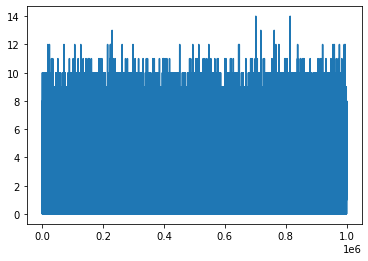

In [145]:
plt.plot(data_buffer)

In [ ]:
edge_config.counter_task_config['N_samples_to_acquire_or_buffer_size']

In [ ]:
N_period = 100
N_cycles = len(data_buffer)/N_period
integrated_data_on = []
integrated_data_off = []
rf_on_sum = 0
rf_off_sum = 0
shift = N_period/4
#for i in range(int(N_cycles/3):int(N_cycles) - 1):
for i in range(int(N_cycles) - 1):
    on_data = data_buffer[int(i*N_period  + shift): int(shift + i*N_period + N_period/2)]
    off_data = data_buffer[int(i*N_period + N_period/2 + shift): int(shift + (i+1)*N_period)]
    rf_on_sum += on_data.sum()
    rf_off_sum += off_data.sum()
    integrated_data_on.append(on_data)
    integrated_data_off.append(off_data)
    
    


In [147]:
integrated_data_on = np.array(integrated_data_on)

In [148]:
integrated_data_off = np.array(integrated_data_off)

In [149]:
integrated_data_on

array([[4., 0., 5., ..., 1., 1., 1.],
       [3., 4., 4., ..., 1., 0., 3.],
       [0., 1., 1., ..., 0., 1., 5.],
       ...,
       [1., 2., 5., ..., 5., 4., 3.],
       [1., 3., 2., ..., 3., 2., 1.],
       [4., 2., 3., ..., 3., 2., 2.]])

In [150]:
signal_on = integrated_data_on.sum(axis=0)
signal_off = integrated_data_off.sum(axis=0)

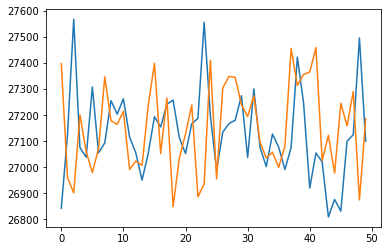

In [151]:
plt.plot(signal_on)
plt.plot(signal_off)

In [152]:
signal_on.mean()/signal_off.mean()

0.9991617986416423

In [ ]:
for i in range

In [29]:
rf_on_sum

521533.0

In [28]:
rf_off_sum

521862.0

In [44]:
rfsynth.rf_off(0)


In [45]:
rf_on_sum

544879.0

In [46]:
rf_off_sum

543887.0

In [47]:
20/530


0.03773584905660377